# SAMOS Spectroscopy Pipeline - Initial Inspection

This notebook covers:
1. Reading raw SAMOS multi-CCD data
2. Creating calibration frames (bias, flat, arc)
3. Detecting spectral traces
4. Extracting individual slit cutouts

**Updated to use the new `samos` package structure**

## 1. Import Packages

In [6]:
# Standard libraries
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from pathlib import Path

# SAMOS pipeline - NEW IMPORTS
from samos.core import mosaic, cosmic_rays, calibration
from samos.spectroscopy import trace_detection
from samos.utils import display, io

# Jupyter display
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ All packages imported successfully!")

✓ All packages imported successfully!


## 2. Configuration

Set your data paths and target information here.

In [7]:
# Target information
target_name = "ABELL3120"
target_mode = "SAMI_manual_Mask_T00_Low_Red"

# Data directories
data_directory = "/Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI"
data_directory_17 = data_directory + "/20241017"
data_directory_16 = data_directory + "/20241016"

# Working directory for outputs
analysis_top_directory = "/Users/nestrada/Documents/SAMOS/SAMOS_REDUCED"
working_directory = os.path.join(analysis_top_directory, target_name, target_mode)

# Create working directory
Path(working_directory).mkdir(parents=True, exist_ok=True)
os.chdir(working_directory)

print(f"Working directory: {working_directory}")
print(f"Data directory: {data_directory}")

Working directory: /Users/nestrada/Documents/SAMOS/SAMOS_REDUCED/ABELL3120/SAMI_manual_Mask_T00_Low_Red
Data directory: /Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI


## 3. Read Science Frame

In [8]:
# Read science frame
science_file = os.path.join(data_directory_17, 'target.027.fits')
print(f"Reading: {science_file}")

# Create mosaic using new package
hdu = mosaic.read_sami_mosaic(science_file)
Target_Spectra = hdu.data

print(f"Mosaic shape: {Target_Spectra.shape}")

# Save to working directory
shutil.copy(science_file, 'TARGET.fits')
print("✓ Science frame read and copied")

Reading: /Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241017/target.027.fits
Mosaic shape: (1428, 4094)
✓ Science frame read and copied


Removing cosmic rays from science frame...
INFO: Iteration 1: Found 1280 cosmic-ray pixels, Total: 1280 [lacosmic.core]
INFO: Iteration 2: Found 65 cosmic-ray pixels, Total: 1345 [lacosmic.core]
INFO: Iteration 3: Found 8 cosmic-ray pixels, Total: 1353 [lacosmic.core]
INFO: Iteration 4: Found 0 cosmic-ray pixels, Total: 1353 [lacosmic.core]
Cosmic rays detected: 1353 pixels (0.02%)


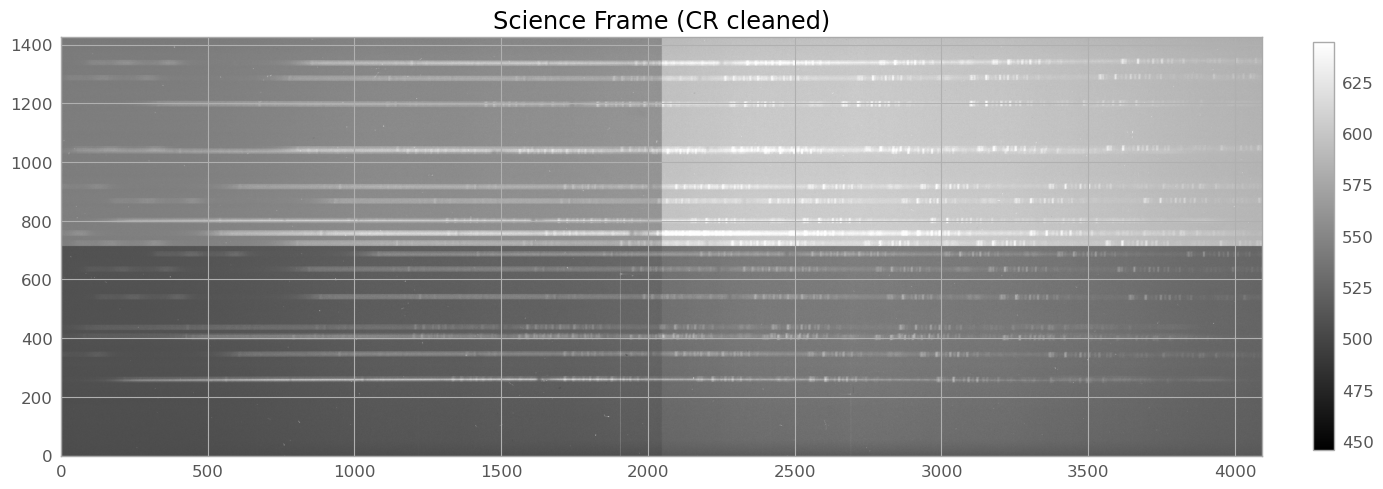

✓ Cosmic rays removed ((1428, 4094))


In [9]:
# Remove cosmic rays
print("Removing cosmic rays from science frame...")
spectra = cosmic_rays.remove_cosmic_rays(Target_Spectra, verbose=True)

# Display
vmin, vmax = display.get_sigma_limits(spectra, n_sigma=3)
display.display_image(spectra, zmin=vmin, zmax=vmax, 
                     title='Science Frame (CR cleaned)')

print(f"✓ Cosmic rays removed ({spectra.shape})")

## 4. Create Calibration Frames

### 4a. Master Flat

Reading flat frames...
  Read: target.028.fits
  Read: calibration.029.fits
Removing cosmic rays from flat...
INFO: Iteration 1: Found 627 cosmic-ray pixels, Total: 627 [lacosmic.core]
INFO: Iteration 2: Found 119 cosmic-ray pixels, Total: 746 [lacosmic.core]
INFO: Iteration 3: Found 34 cosmic-ray pixels, Total: 780 [lacosmic.core]
INFO: Iteration 4: Found 12 cosmic-ray pixels, Total: 792 [lacosmic.core]


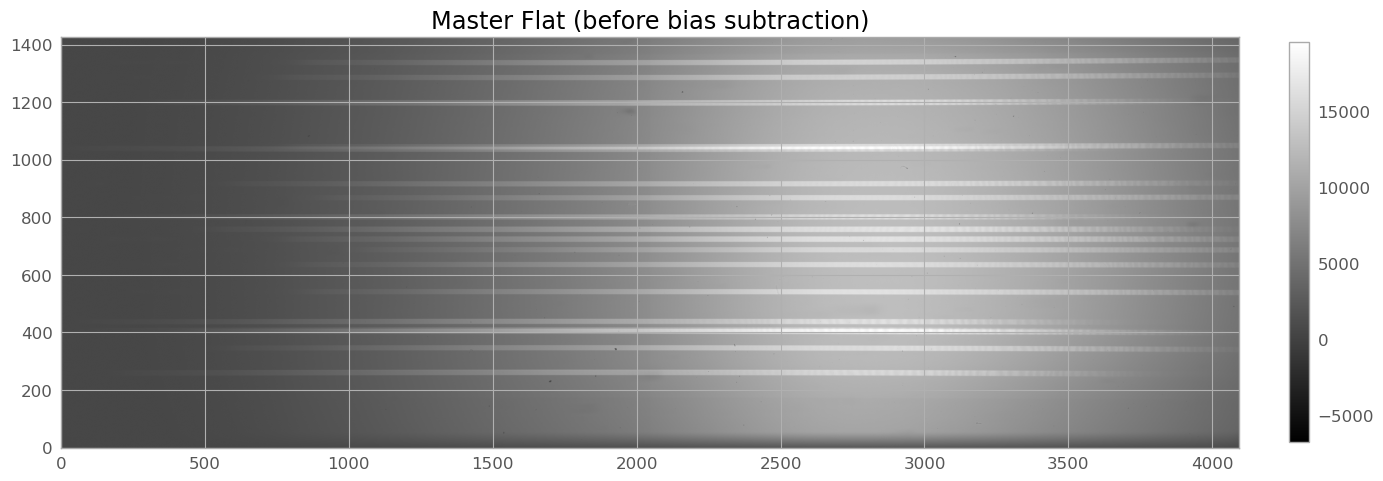

Wrote: FLAT.fits
✓ Master flat created


In [10]:
# Read flat frames
flat_files = [
    os.path.join(data_directory_17, 'target.028.fits'),
    os.path.join(data_directory_17, 'calibration.029.fits')
]

print("Reading flat frames...")
flat_mosaics = []
for flat_file in flat_files:
    hdu = mosaic.read_sami_mosaic(flat_file)
    flat_mosaics.append(hdu.data)
    print(f"  Read: {Path(flat_file).name}")

# Combine flats (no bias subtraction yet)
master_flat_raw = calibration.create_master_flat(
    flat_mosaics, 
    master_bias=None,  # Will subtract bias later
    normalize=False    # Will normalize after bias subtraction
)

# Remove cosmic rays
print("Removing cosmic rays from flat...")
flat = cosmic_rays.remove_cosmic_rays(master_flat_raw, verbose=False)

# Display
vmin, vmax = display.get_sigma_limits(flat, n_sigma=3)
display.display_image(flat, zmin=vmin, zmax=vmax, 
                     title='Master Flat (before bias subtraction)')

# Save
io.write_fits(flat, 'FLAT.fits')
print("✓ Master flat created")

### 4b. Master Bias

Found 20 bias frames
Reading bias frames...
  Read 5/20 frames...
  Read 10/20 frames...
  Read 15/20 frames...
  Read 20/20 frames...
Combining bias frames...
Removing cosmic rays from bias...
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.core]


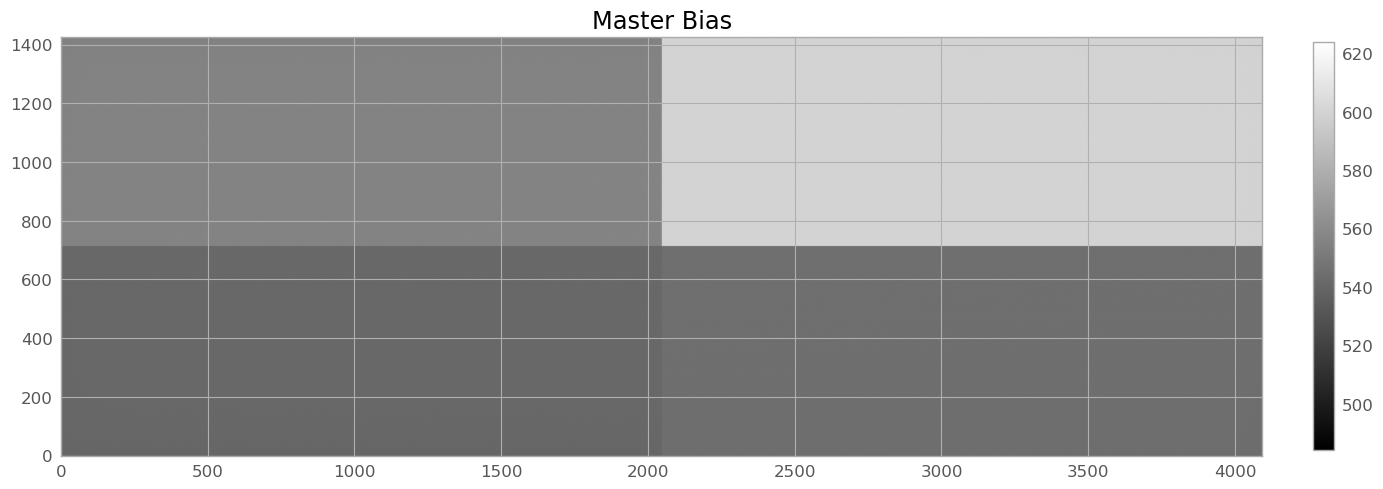

Wrote: BIAS.fits
✓ Master bias created


In [11]:
# Find all bias frames
bias_pattern = 'bias.0[5-7][0-9].fits'
bias_files = io.find_files(data_directory_16, bias_pattern)
print(f"Found {len(bias_files)} bias frames")

# Read all bias frames
print("Reading bias frames...")
bias_mosaics = []
for i, bias_file in enumerate(bias_files):
    hdu = mosaic.read_sami_mosaic(bias_file)
    bias_mosaics.append(hdu.data)
    if (i+1) % 5 == 0:
        print(f"  Read {i+1}/{len(bias_files)} frames...")

# Create master bias
print("Combining bias frames...")
bias = calibration.create_master_bias(bias_mosaics, method='median')

# Remove cosmic rays
print("Removing cosmic rays from bias...")
bias = cosmic_rays.remove_cosmic_rays(bias, verbose=False)

# Display
vmin, vmax = display.get_sigma_limits(bias, n_sigma=3)
display.display_image(bias, zmin=vmin, zmax=vmax, 
                     title='Master Bias')

# Save
io.write_fits(bias, 'BIAS.fits')
print("✓ Master bias created")

### 4c. Bias-Subtracted Calibrations

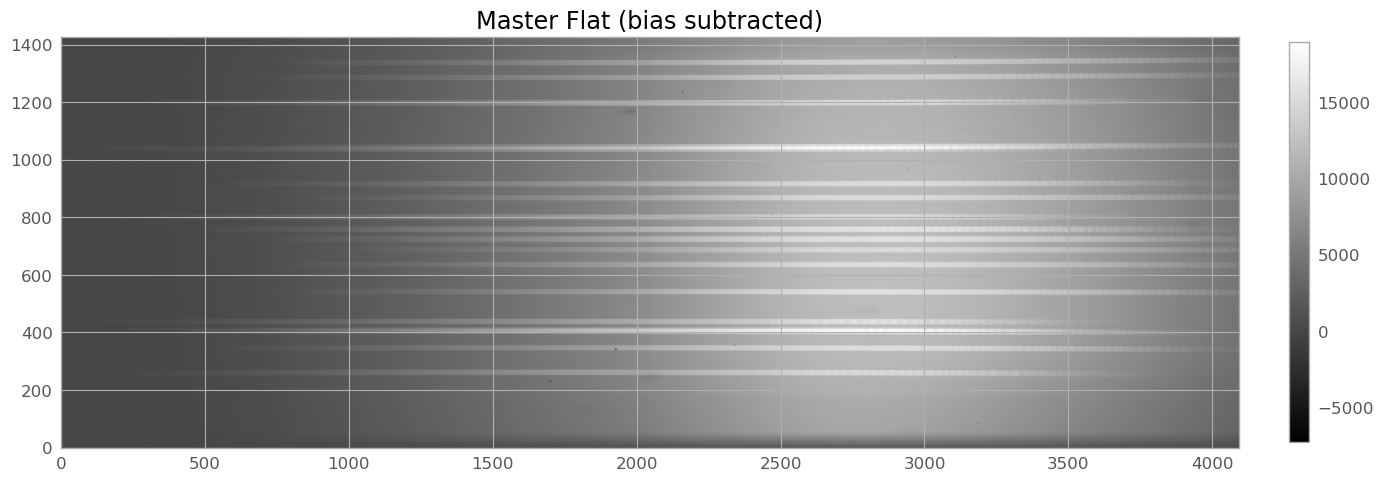

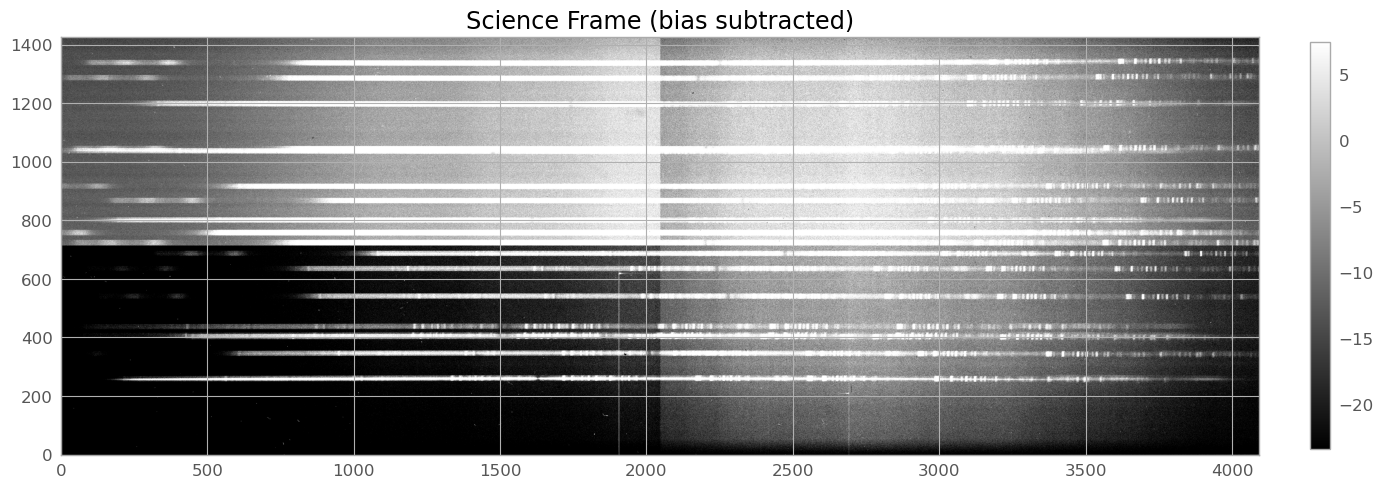

✓ Bias subtracted from flat and science frames


In [12]:
# Subtract bias from flat
flat_bias = calibration.apply_bias_correction(flat, bias)

# Display
vmin, vmax = display.get_sigma_limits(flat_bias, n_sigma=3)
display.display_image(flat_bias, zmin=vmin, zmax=vmax, 
                     title='Master Flat (bias subtracted)')

# Subtract bias from science
spectra_bias = calibration.apply_bias_correction(spectra, bias)

# Display
vmin, vmax = display.get_sigma_limits(spectra_bias, n_sigma=1)
display.display_image(spectra_bias, zmin=vmin, zmax=vmax, 
                     title='Science Frame (bias subtracted)')

print("✓ Bias subtracted from flat and science frames")

## 5. Process Arc Lamp for Trace Detection

Reading arc lamp: /Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241017/calibration.032.fits
Removing cosmic rays from arc...
INFO: Iteration 1: Found 37263 cosmic-ray pixels, Total: 37263 [lacosmic.core]
INFO: Iteration 2: Found 8640 cosmic-ray pixels, Total: 45903 [lacosmic.core]
INFO: Iteration 3: Found 2688 cosmic-ray pixels, Total: 48591 [lacosmic.core]
INFO: Iteration 4: Found 1366 cosmic-ray pixels, Total: 49957 [lacosmic.core]
Cosmic rays detected: 49957 pixels (0.85%)
Wrote: ARC.fits


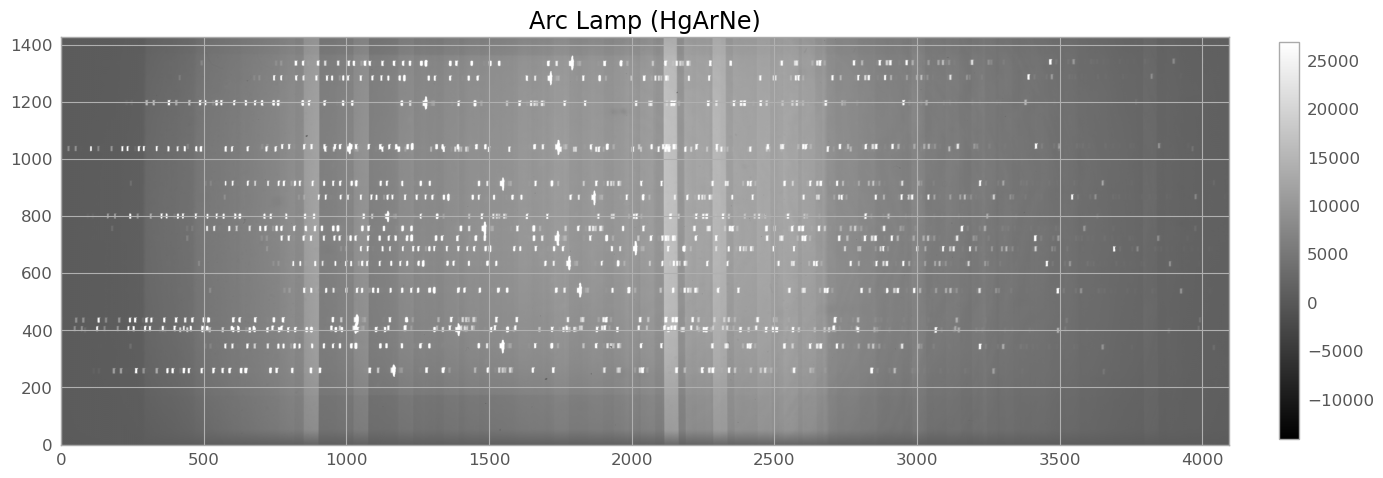

✓ Arc lamp read


In [13]:
# Read arc lamp
arc_file = os.path.join(data_directory_17, 'calibration.032.fits')
print(f"Reading arc lamp: {arc_file}")

hdu = mosaic.read_sami_mosaic(arc_file)
arc = hdu.data

# Remove cosmic rays
print("Removing cosmic rays from arc...")
arc = cosmic_rays.remove_cosmic_rays(arc, verbose=True)

# Save
io.write_fits(arc, 'ARC.fits')

# Display
vmin, vmax = display.get_sigma_limits(arc, n_sigma=3)
display.display_image(arc, zmin=vmin, zmax=vmax, 
                     title='Arc Lamp (HgArNe)')

print("✓ Arc lamp read")

Reading arc dark: /Users/nestrada/Documents/SAMOS/_Run2/Data/SAMI/20241017/calibration.035.fits
Removing cosmic rays from arc dark...
INFO: Iteration 1: Found 1355 cosmic-ray pixels, Total: 1355 [lacosmic.core]
INFO: Iteration 2: Found 135 cosmic-ray pixels, Total: 1490 [lacosmic.core]
INFO: Iteration 3: Found 32 cosmic-ray pixels, Total: 1522 [lacosmic.core]
INFO: Iteration 4: Found 6 cosmic-ray pixels, Total: 1528 [lacosmic.core]
Wrote: ARC_noDMD.fits


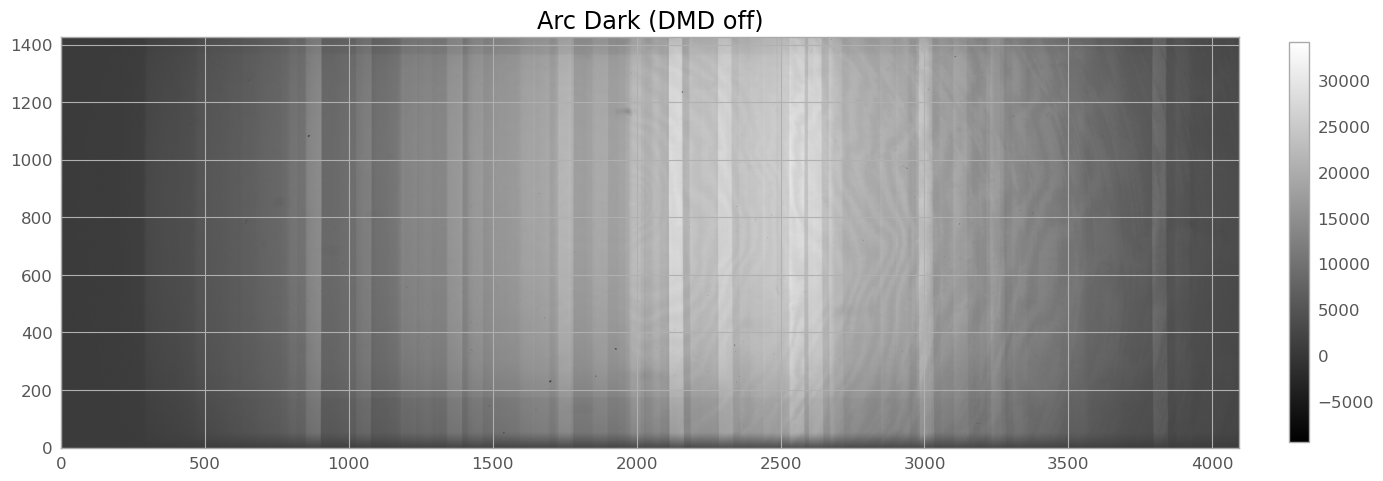

✓ Arc dark read


In [14]:
# Read arc dark (DMD off)
arc_dark_file = os.path.join(data_directory_17, 'calibration.035.fits')
print(f"Reading arc dark: {arc_dark_file}")

hdu_noDMD = mosaic.read_sami_mosaic(arc_dark_file)
arc_noDMD = hdu_noDMD.data

# Remove cosmic rays
print("Removing cosmic rays from arc dark...")
arc_noDMD = cosmic_rays.remove_cosmic_rays(arc_noDMD, verbose=False)

# Save
io.write_fits(arc_noDMD, 'ARC_noDMD.fits')

# Display
vmin, vmax = display.get_sigma_limits(arc_noDMD, n_sigma=3)
display.display_image(arc_noDMD, zmin=vmin, zmax=vmax, 
                     title='Arc Dark (DMD off)')

print("✓ Arc dark read")

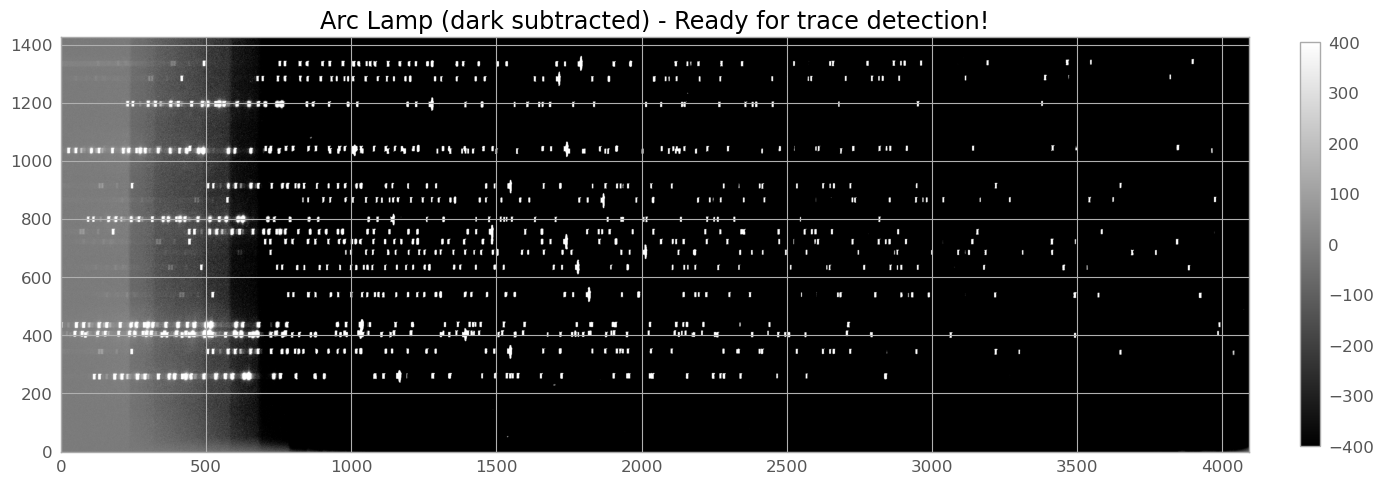

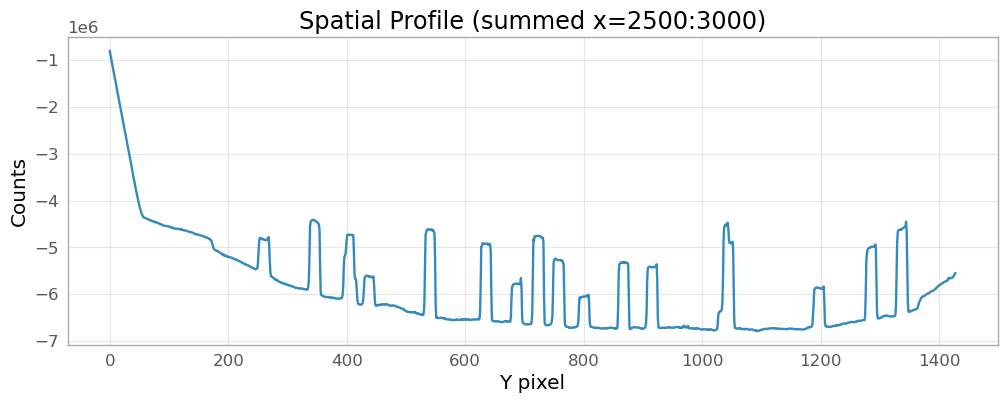

✓ Arc looks good for trace detection!


In [15]:
# Subtract arc dark
arc_good = arc - arc_noDMD

# Display
display.display_image(arc_good, zmin=-400, zmax=400, 
                     title='Arc Lamp (dark subtracted) - Ready for trace detection!')

# Plot collapsed spatial profile
spatial_profile = arc_good[:, 2500:3000].sum(axis=1)
plt.figure(figsize=(12, 4))
plt.plot(spatial_profile)
plt.xlabel('Y pixel')
plt.ylabel('Counts')
plt.title('Spatial Profile (summed x=2500:3000)')
plt.grid(alpha=0.3)
plt.show()

print("✓ Arc looks good for trace detection!")

## 6. Detect Spectral Traces

Using the new `trace_detection` module!

In [16]:
# Detect traces automatically using the new module
print("Detecting spectral traces...\n")

slits = trace_detection.detect_traces_from_arc(
    arc_good,
    arc_dark=None,  # Already subtracted
    x_range=(1500, 2000),
    peak_threshold=4e5,
    margin=12,
    verbose=True
)

print(f"\n✓ Detected {len(slits)} spectral traces!")
print(f"\nSlit definitions (format: [y0, y1_trace, y2_trace, y3]):")
for i, slit in enumerate(slits[:5]):  # Show first 5
    print(f"  Slit {i:2d}: {slit}")
print("  ...")

Detecting spectral traces...


Detecting edges in x-range (1500, 2000)...
Found 18 upper edges and 18 lower edges
Slit 2: 396-413 conflicts with next slit, removing
Slit 3: 400-418 conflicts with previous slit, removing
Slit 13: 1026-1044 conflicts with next slit, removing
Slit 14: 1035-1053 conflicts with previous slit, removing

Removed 4 overlapping slits
Final count: 14 slits

Final slit definitions:
Slit  0: y=[ 241: 283] (total dy=42, spectrum dy=18)
Slit  1: y=[ 327: 368] (total dy=41, spectrum dy=17)
Slit  2: y=[ 418: 460] (total dy=42, spectrum dy=18)
Slit  3: y=[ 521: 563] (total dy=42, spectrum dy=18)
Slit  4: y=[ 615: 657] (total dy=42, spectrum dy=18)
Slit  5: y=[ 666: 708] (total dy=42, spectrum dy=18)
Slit  6: y=[ 702: 745] (total dy=43, spectrum dy=19)
Slit  7: y=[ 737: 779] (total dy=42, spectrum dy=18)
Slit  8: y=[ 780: 821] (total dy=41, spectrum dy=17)
Slit  9: y=[ 846: 888] (total dy=42, spectrum dy=18)
Slit 10: y=[ 895: 937] (total dy=42, spectrum dy=18)
Slit 11: 

## 7. Visualize Detected Traces

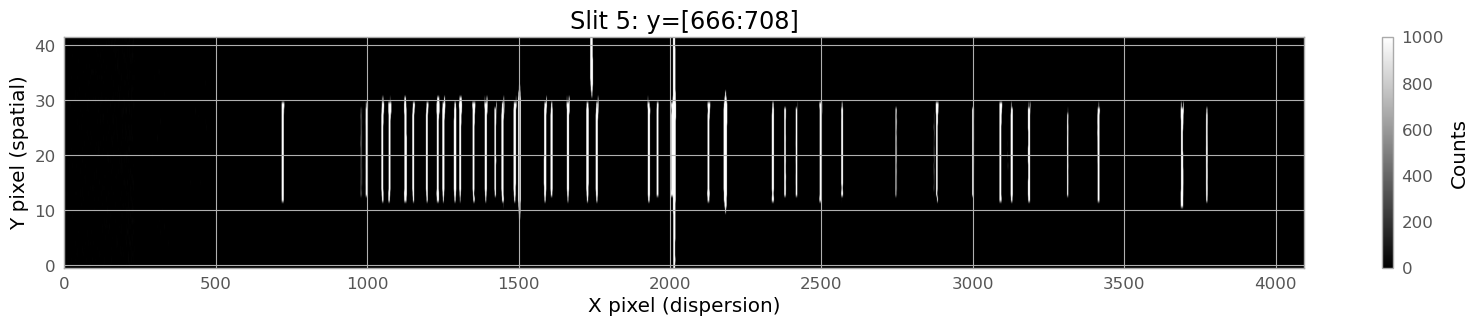

Slit 5 shape: (42, 4094)


In [17]:
# Plot a single slit
i_slit = 5
slit = slits[i_slit]

plt.figure(figsize=(20, 3))
plt.imshow(arc_good[slit[0]:slit[3], :], 
           origin='lower', cmap='gray', vmin=0, vmax=1000, aspect='auto')
plt.title(f'Slit {i_slit}: y=[{slit[0]}:{slit[3]}]')
plt.xlabel('X pixel (dispersion)')
plt.ylabel('Y pixel (spatial)')
plt.colorbar(label='Counts')
plt.show()

print(f"Slit {i_slit} shape: {arc_good[slit[0]:slit[3], :].shape}")

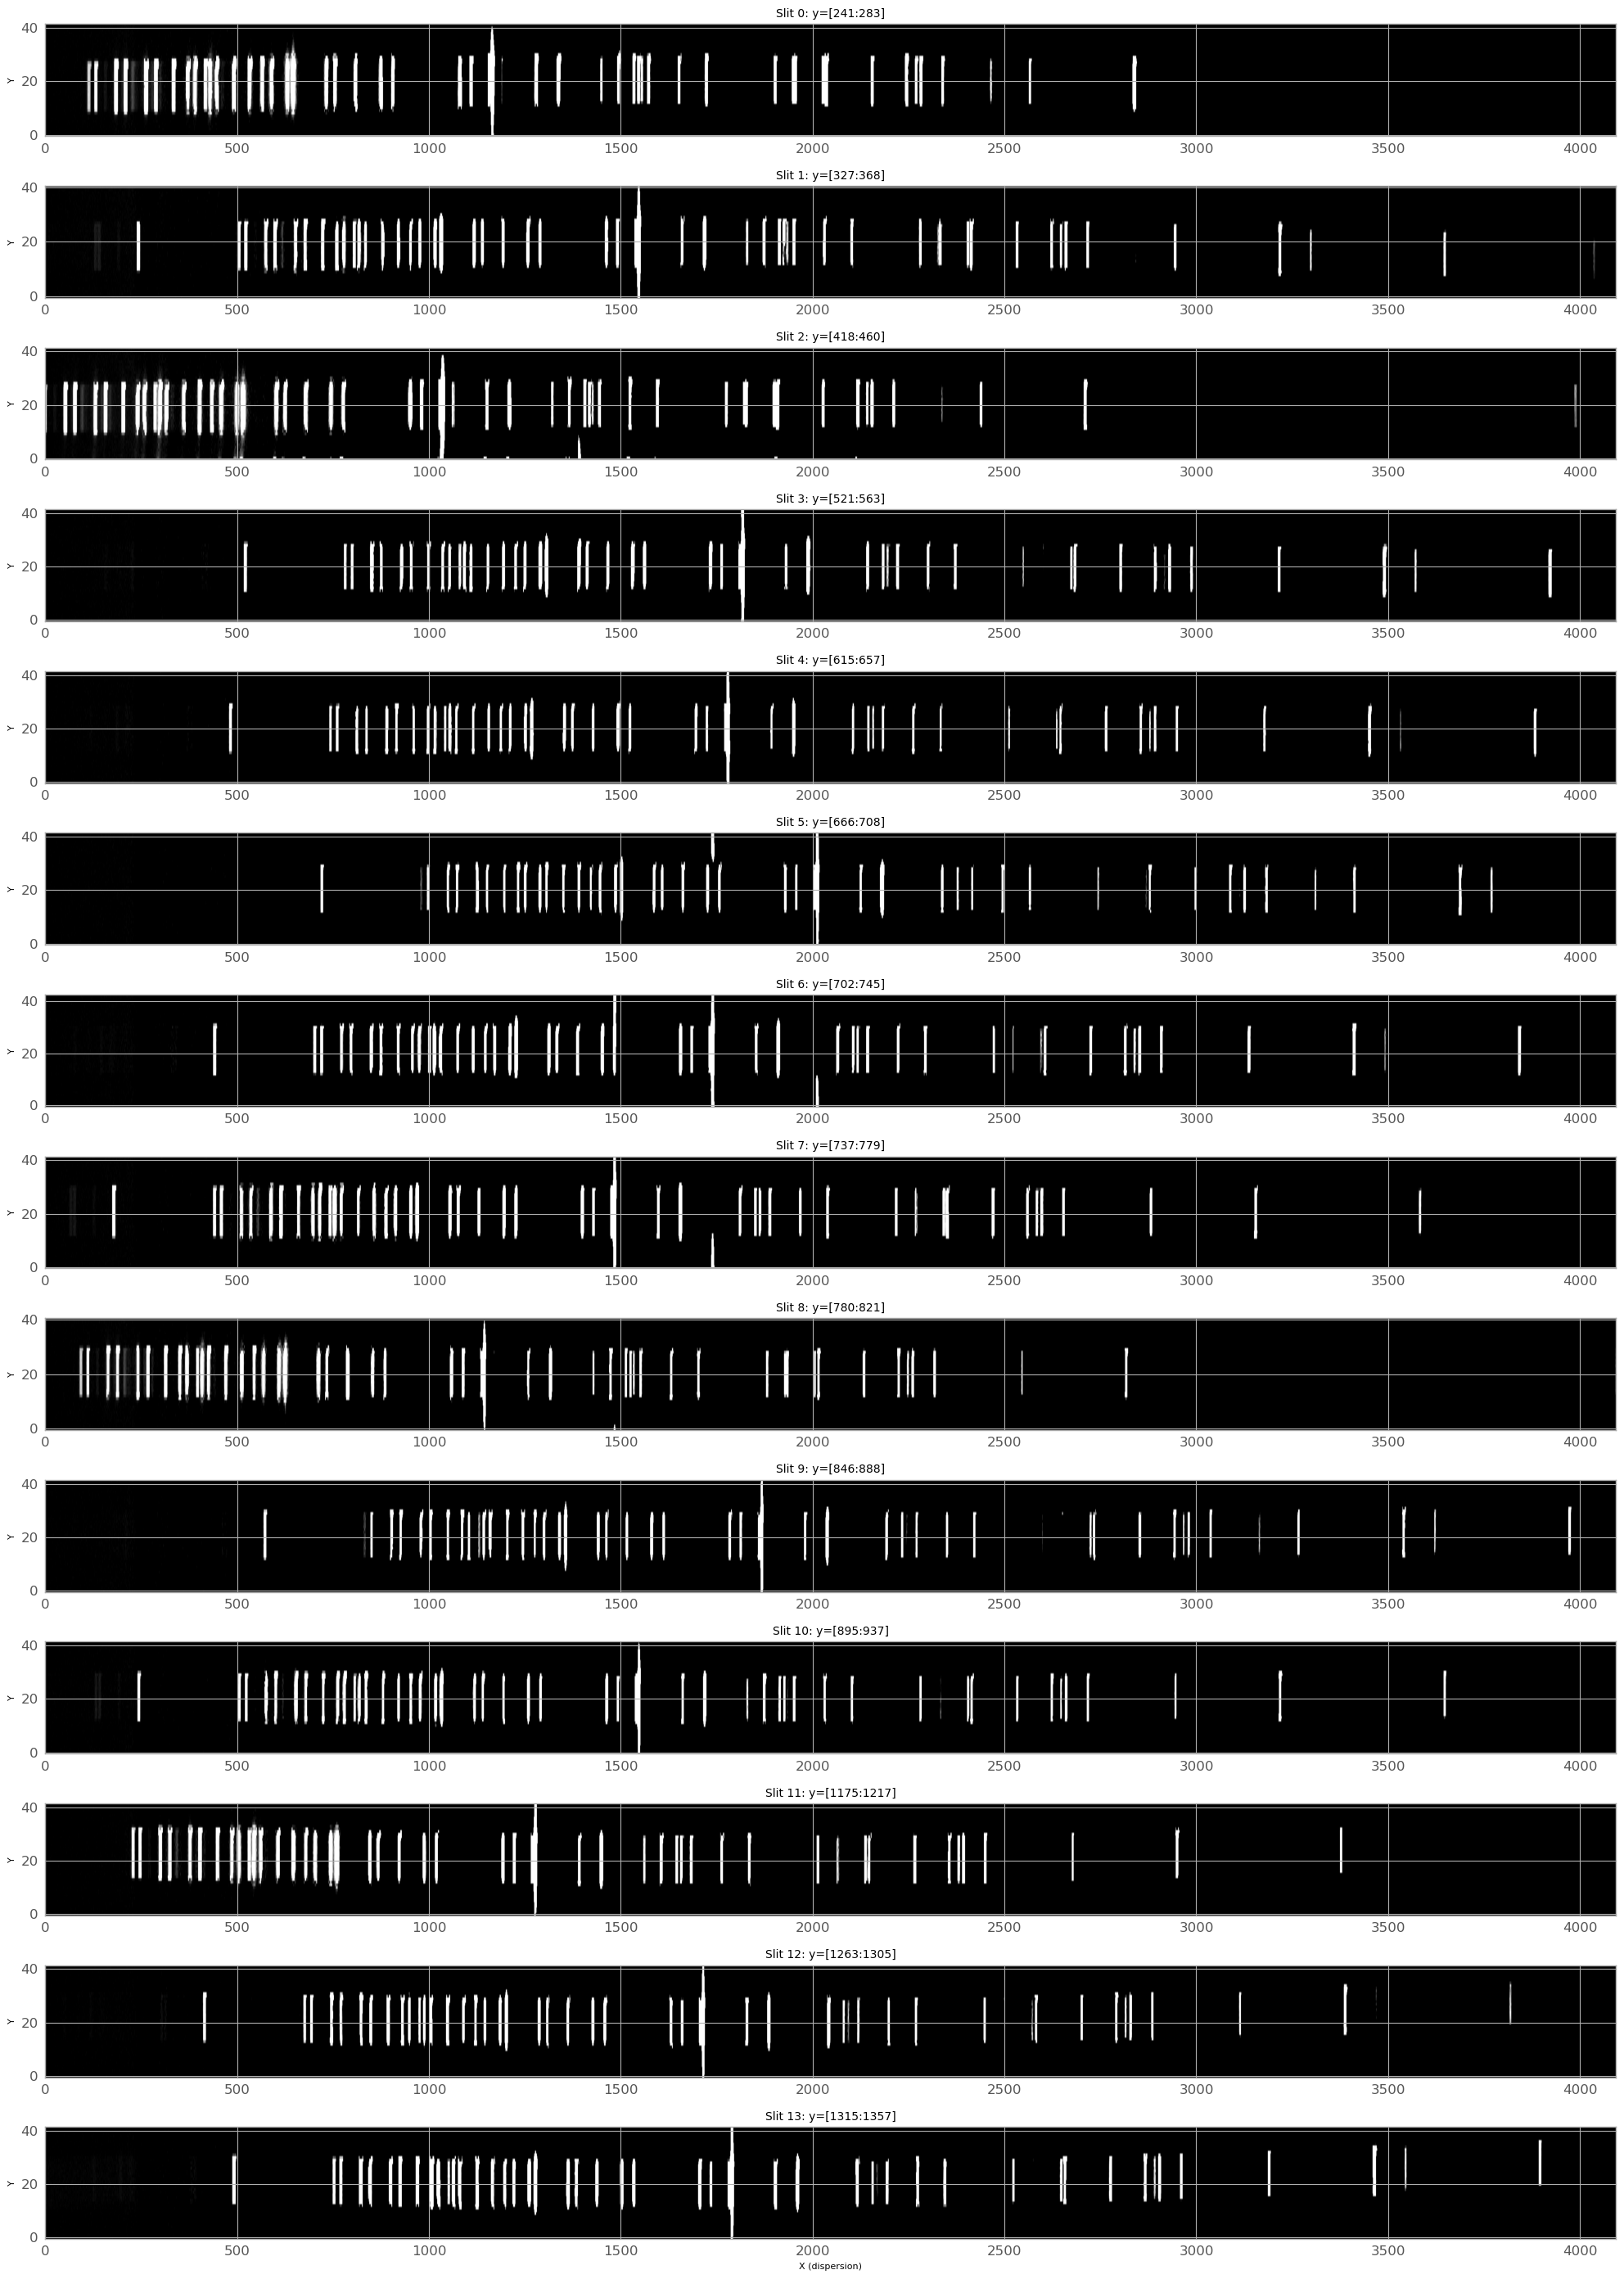

✓ Displayed all 14 slit cutouts


In [18]:
# Plot all slits (arc)
fig, axes = plt.subplots(len(slits), 1, figsize=(20, len(slits)*2))

for i, (ax, slit) in enumerate(zip(axes, slits)):
    cutout = arc_good[slit[0]:slit[3], :]
    ax.imshow(cutout, origin='lower', cmap='gray', vmin=0, vmax=1000, aspect='auto')
    ax.set_title(f'Slit {i}: y=[{slit[0]}:{slit[3]}]', fontsize=10)
    ax.set_ylabel('Y', fontsize=8)
    if i == len(slits) - 1:
        ax.set_xlabel('X (dispersion)', fontsize=8)

plt.tight_layout()
plt.show()

print(f"✓ Displayed all {len(slits)} slit cutouts")

## 8. Extract and Save Individual Slits

In [19]:
# Extract slit cutouts and save as multi-extension FITS
print("Extracting and saving individual slits...\n")

for i_s, slit in enumerate(slits):
    # Extract cutouts
    data_cutout = spectra_bias[slit[0]:slit[3], :]
    flat_cutout = flat_bias[slit[0]:slit[3], :]
    line_cutout = arc_good[slit[0]:slit[3], :]
    
    # Create FITS header
    hdr = fits.Header()
    hdr['SLIT'] = i_s
    hdr['Y0'] = (slit[0], 'y[0] pixel of the 2D cut')
    hdr['Y1'] = (slit[1], 'y[0] pixel of the trace')
    hdr['Y2'] = (slit[2], 'y[1] pixel of the trace')
    hdr['Y3'] = (slit[3], 'y[1] pixel of the 2D cut')
    hdr['TARGET'] = target_name
    hdr['MODE'] = target_mode
    
    # Create multi-extension FITS
    primary_hdu = fits.PrimaryHDU(header=hdr)
    data_hdu = fits.ImageHDU(data=data_cutout, name='DATA')
    flat_hdu = fits.ImageHDU(data=flat_cutout, name='FLAT')
    line_hdu = fits.ImageHDU(data=line_cutout, name='LINES')
    
    hdulist = fits.HDUList([primary_hdu, data_hdu, flat_hdu, line_hdu])
    
    # Save
    output_file = f'spec_{i_s:03d}.fits'
    hdulist.writeto(output_file, overwrite=True)
    hdulist.close()
    
    if (i_s + 1) % 5 == 0 or i_s == len(slits) - 1:
        print(f"  Saved {i_s + 1}/{len(slits)} slits...")

print(f"\n✓ All {len(slits)} slits extracted and saved!")
print(f"\nOutput location: {working_directory}")
print(f"Files: spec_000.fits to spec_{len(slits)-1:03d}.fits")

Extracting and saving individual slits...

  Saved 5/14 slits...
  Saved 10/14 slits...
  Saved 14/14 slits...

✓ All 14 slits extracted and saved!

Output location: /Users/nestrada/Documents/SAMOS/SAMOS_REDUCED/ABELL3120/SAMI_manual_Mask_T00_Low_Red
Files: spec_000.fits to spec_013.fits


## Summary

This notebook has:

1. ✅ Read raw SAMOS multi-CCD data using `samos.core.mosaic`
2. ✅ Created master calibration frames using `samos.core.calibration`
3. ✅ Removed cosmic rays using `samos.core.cosmic_rays`
4. ✅ Detected spectral traces using `samos.spectroscopy.trace_detection`
5. ✅ Extracted individual slit cutouts and saved as multi-extension FITS

**Next steps:**
- Continue to notebook `04_trace_extraction.ipynb` for trace fitting and rectification
- Or use `05_wavelength_calibration.ipynb` for wavelength solution

**Files created:**
- Master calibrations: `BIAS.fits`, `FLAT.fits`, `ARC.fits`
- Individual slits: `spec_000.fits` to `spec_013.fits` (or however many slits detected)

Each slit FITS file contains:
- Extension 0 (PRIMARY): Header with slit information
- Extension 1 (DATA): Science data cutout
- Extension 2 (FLAT): Flat field cutout
- Extension 3 (LINES): Arc lamp cutout